In [51]:
import tensorflow as tf
from pydub import AudioSegment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report


In [31]:
dataset_path = "final_data"

train_data = tf.keras.utils.audio_dataset_from_directory(
    dataset_path,
    batch_size = 4,
    shuffle = True,
    validation_split = 0.2,
    subset = "training",
    output_sequence_length = 48000,
    ragged = False,
    label_mode = "categorical",
    labels = "inferred",
    sampling_rate = None,
    seed = 59
)


validation_data = tf.keras.utils.audio_dataset_from_directory(
    dataset_path,
    batch_size = 4,
    shuffle = False,
    validation_split = 0.2,
    subset = "validation",
    output_sequence_length = 48000,
    ragged = False,
    label_mode = "categorical",
    labels = "inferred",
    sampling_rate = None,
    seed = 59
)

Found 1895 files belonging to 16 classes.
Using 1516 files for training.
Found 1895 files belonging to 16 classes.
Using 379 files for validation.


In [32]:
train_labels = np.concatenate([y for x, y in train_data], axis=0)
val_labels = np.concatenate([y for x, y in validation_data], axis=0)

print("Training Class Distribution:", np.unique(np.argmax(train_labels, axis=1), return_counts=True))
print("Validation Class Distribution:", np.unique(np.argmax(val_labels, axis=1), return_counts=True))


Training Class Distribution: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=int64), array([103, 121,  69,  68,  49,  70,  97,  90, 113,  40,  73,  69, 109,
        69, 223, 153], dtype=int64))
Validation Class Distribution: (array([14, 15], dtype=int64), array([197, 182], dtype=int64))


In [33]:

model = models.Sequential([
    
    layers.Conv1D(64, kernel_size=80, strides=16, activation="relu", input_shape=(48000, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=4),
    
    
    layers.Conv1D(128, kernel_size=3, activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=4),
    

    layers.Conv1D(256, kernel_size=3, activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=4),
    layers.Dropout(0.3),  

  
    layers.Conv1D(512, kernel_size=3, activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=4),
    layers.Dropout(0.4),  

    
    layers.GlobalAveragePooling1D(),
    layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01)),  
    layers.Dropout(0.5),  
    layers.Dense(16, activation="softmax")  
])


In [34]:

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [35]:

early_stopping = EarlyStopping(
    monitor="val_loss",  
    patience=5,          
    restore_best_weights=True  
)


reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",   
    factor=0.5,          
    patience=3,          
    min_lr=1e-6           
)

history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=20,
    callbacks=[early_stopping, reduce_lr] 
)

model.save("final_model.keras")

Epoch 1/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 236s 605ms/step - accuracy: 0.2413 - loss: 4.4454 - val_accuracy: 0.0000e+00 - val_loss: 7.6050 - learning_rate: 0.0010
Epoch 2/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 250s 661ms/step - accuracy: 0.4465 - loss: 2.7683 - val_accuracy: 0.8496 - val_loss: 1.3986 - learning_rate: 0.0010
Epoch 3/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 230s 607ms/step - accuracy: 0.5844 - loss: 2.0258 - val_accuracy: 0.8602 - val_loss: 1.0008 - learning_rate: 0.0010
Epoch 4/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 215s 567ms/step - accuracy: 0.6262 - loss: 1.6929 - val_accuracy: 0.9604 - val_loss: 0.5902 - learning_rate: 0.0010
Epoch 5/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 258s 555ms/step - accuracy: 0.6770 - loss: 1.4419 - val_accuracy: 0.9156 - val_loss: 0.7684 - learning_rate: 0.0010
Epoch 6/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 207s 547ms/step - accuracy: 0.7023 - loss: 1.2961 - val_accuracy: 0.8602 - val_loss: 0.7841 - learning_rate: 0.0010
Epoch 7/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 207s 547ms/step - ac

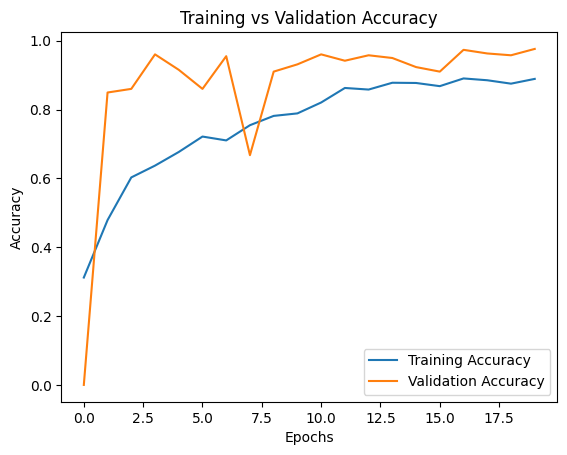

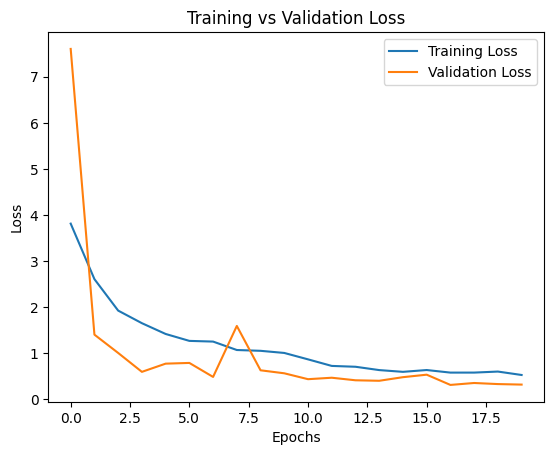

In [42]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


In [43]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

final_metrics = {
    "Epoch": len(train_accuracy),
    "Train Accuracy": train_accuracy[-1],
    "Validation Accuracy": val_accuracy[-1],
    "Train Loss": train_loss[-1],
    "Validation Loss": val_loss[-1]
}

final_metrics_df = pd.DataFrame([final_metrics])


print("\nFinal Training and Validation Metrics:\n")
print(final_metrics_df.to_string(index=False))



Final Training and Validation Metrics:

 Epoch  Train Accuracy  Validation Accuracy  Train Loss  Validation Loss
    20        0.889182             0.976253    0.522204         0.313532


In [44]:
predictions = model.predict(validation_data)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.concatenate([y for x, y in validation_data], axis=0)
true_labels = np.argmax(true_labels, axis=1)

95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


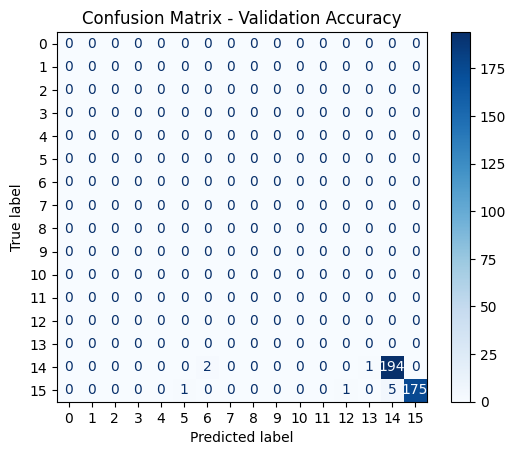

In [45]:
class_labels = list(range(16))  # All 16 classes
cm = confusion_matrix(true_labels, predicted_labels, labels=class_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Validation Accuracy')
plt.show()




In [46]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.97      0.98      0.98       197
          15       1.00      0.96      0.98       182

    accuracy                           0.97       379
   macro avg       0.33      0.32      0.33       379
weighted avg       0.99      0.97      0.98       379



c:\Users\Dr.Laptop\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dr.Laptop\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dr.Laptop\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

In [54]:
def predict_audio(audio_path):
   
    audio = AudioSegment.from_file(audio_path)
    audio = audio.set_channels(1).set_frame_rate(48000)  
    audio = audio.set_sample_width(2) 
    processed_audio_path = "audio.wav"
    audio.export(processed_audio_path, format="wav")
    
   
    audio_binary = tf.io.read_file(processed_audio_path)
    audio_tensor, sample_rate = tf.audio.decode_wav(
        audio_binary, desired_channels=1, desired_samples=48000
    )
    
    
    audio_tensor = tf.expand_dims(audio_tensor, axis=0)  

    
    predictions = model.predict(audio_tensor)
    predicted_class = np.argmax(predictions, axis=1)  
    return predicted_class[0]


audio_path = "bazazzan.wav"
predicted_class = predict_audio(audio_path)
print(f"Predicted class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Predicted class: 1
